In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [3]:
# stuff that should be in HARK proper

def dcegmSegments(x, v):
    """
    Find index vectors `rise` and `fall` such that `rise` holds the indeces `i`
    such that x[i+1]>x[i] and `fall` holds indeces `j` such that either
    - x[j+1] < x[j] or,
    - x[j]>x[j-1] and v[j]<v[j-1].

    The vectors are essential to the DCEGM algorithm, as they definite the
    relevant intervals to be used to construct the upper envelope of potential
    solutions to the (necessary) first order conditions.

    Parameters
    ----------
    x : np.ndarray
        array of points where `v` is evaluated
    v : np.ndarray
        array of values of some function of `x`

    Returns
    -------
    rise : np.ndarray
        see description above
    fall : np.ndarray
        see description above
    """
    # NOTE: assumes that the first segment is in fact increasing (forced in EGM
    # by augmentation with the constrained segment).
    # elements in common grid g

    # Identify index intervals of falling and rising regions
    # We need these to construct the upper envelope because we need to discard
    # solutions from the inverted Euler equations that do not represent optimal
    # choices (the FOCs are only necessary in these models).
    #
    # `fall` is a vector of indeces that represent the first elements in all
    # of the falling segments (the curve can potentially fold several times)
    fall = np.empty(0, dtype=int) # initialize with empty and then add the last point below while-loop

    rise = np.array([0]) # Initialize such thatthe lowest point is the first grid point
    i = 1 # Initialize
    while i <= len(x) - 2:
        # Check if the next (`ip1` stands for i plus 1) grid point is below the
        # current one, such that the line is folding back.
        ip1_falls = x[i+1] < x[i] # true if grid decreases on index increment
        i_rose = x[i] > x[i-1] # true if grid decreases on index decrement
        val_fell = v[i] < v[i-1] # true if value rises on index decrement

        if (ip1_falls and i_rose) or (val_fell and i_rose):

            # we are in a region where the endogenous grid is decreasing or
            # the value function rises by stepping back in the grid.
            fall = np.append(fall, i) # add the index to the vector

            # We now iterate from the current index onwards until we find point
            # where resources rises again. Unfortunately, we need to check
            # each points, as there can be multiple spells of falling endogenous
            # grids, so we cannot use bisection or some other fast algorithm.
            k = i
            while x[k+1] < x[k]:
                k = k + 1
            # k now holds either the next index the starts a new rising
            # region, or it holds the length of M, `m_len`.

            rise = np.append(rise, k)

            # Set the index to the point where resources again is rising
            i = k

        i = i + 1

    fall = np.append(fall, len(v)-1)

    return rise, fall
# think! nanargmax makes everythign super ugly because numpy changed the wraning
# in all nan slices to a valueerror...it's nans, aaarghgghg
def calcMultilineEnvelope(M, C, V_T, commonM):
    """
    Do the envelope step of the DCEGM algorithm. Takes in market ressources,
    consumption levels, and inverse values from the EGM step. These represent
    (m, c) pairs that solve the necessary first order conditions. This function
    calculates the optimal (m, c, v_t) pairs on the commonM grid.

    Parameters
    ----------
    M : np.array
        market ressources from EGM step
    C : np.array
        consumption from EGM step
    V_T : np.array
        transformed values at the EGM grid
    commonM : np.array
        common grid to do upper envelope calculations on

    Returns
    -------


    """
    m_len = len(commonM)
    rise, fall = dcegmSegments(M, V_T)

    # Add the last point to the vector for convenience below
    num_kinks = len(fall) # number of kinks / falling EGM grids

    # Use these segments to sequentially find upper envelopes. commonVARNAME
    # means the VARNAME evaluated on the common grid with a cloumn for each kink
    # discovered in dcegmSegments. This means that commonVARNAME is a matrix
    # common grid length-by-number of segments to consider. In the end, we'll
    # use nanargmax over the columns to pick out the best (transformed) values.
    # This is why we fill the arrays with np.nan's.
    commonV_T = np.empty((m_len, num_kinks))
    commonV_T[:] = np.nan
    commonC = np.empty((m_len, num_kinks))
    commonC[:] = np.nan

    # Now, loop over all segments as defined by the "kinks" or the combination
    # of "rise" and "fall" indeces. These (rise[j], fall[j]) pairs define regions
    for j in range(num_kinks):
        # Find points in the common grid that are in the range of the points in
        # the interval defined by (rise[j], fall[j]).
        below = M[rise[j]] >= commonM # boolean array of bad indeces below
        above = M[fall[j]] <= commonM # boolen array of bad indeces above
        in_range = below + above == 0 # pick out elements that are neither

        # create range of indeces in the input arrays
        idxs = range(rise[j], fall[j]+1)
        # grab ressource values at the relevant indeces
        m_idx_j = M[idxs]

        # based in in_range, find the relevant ressource values to interpolate
        m_eval = commonM[in_range]

        # re-interpolate to common grid
        commonV_T[in_range,j] = LinearInterp(m_idx_j, V_T[idxs], lower_extrap=True)(m_eval)
        commonC[in_range,j]  = LinearInterp(m_idx_j, C[idxs], lower_extrap=True)(m_eval) # Interpolat econsumption also. May not be nesserary
    # for each row in the commonV_T matrix, see if all entries are np.nan. This
    # would mean that we have no valid value here, so we want to use this boolean
    # vector to filter out irrelevant entries of commonV_T.
    row_all_nan = np.array([np.all(np.isnan(row)) for row in commonV_T])
    # Now take the max of all these line segments.
    idx_max = np.zeros(commonM.size, dtype = int)
    idx_max[row_all_nan == False] = np.nanargmax(commonV_T[row_all_nan == False], axis=1)

    # prefix with upper for variable that are "upper enveloped"
    upperV_T = np.zeros(m_len)

    # Set the non-nan rows to the maximum over columns
    upperV_T[row_all_nan == False] = np.nanmax(commonV_T[row_all_nan == False, :], axis=1)
    # Set the rest to nan
    upperV_T[row_all_nan] = np.nan

    # Add the zero point in the bottom
    if np.isnan(upperV_T[0]):
        # in transformed space space, utility of zero-consumption (-inf) is 0.0
        upperV_T[0] = 0.0
        # commonM[0] is typically 0, so this is safe, but maybe it should be 0.0
        commonC[0]  = commonM[0]

    # Extrapolate if NaNs are introduced due to the common grid
    # going outside all the sub-line segments
    IsNaN = np.isnan(upperV_T)
    upperV_T[IsNaN] = LinearInterp(commonM[IsNaN == False], upperV_T[IsNaN == False])(commonM[IsNaN])


    LastBeforeNaN = np.append(np.diff(IsNaN)>0, 0)
    LastId = LastBeforeNaN*idx_max # Find last id-number
    idx_max[IsNaN] = LastId[IsNaN]
    # Linear index used to get optimal consumption based on "id"  from max
    ncols = commonC.shape[1]
    rowidx = np.cumsum(ncols*np.ones(len(commonM), dtype=int))-ncols
    idx_linear = np.unravel_index(rowidx+idx_max, commonC.shape)
    upperC = commonC[idx_linear]
    upperC[IsNaN] = LinearInterp(commonM[IsNaN==0], upperC[IsNaN==0])(commonM[IsNaN])

    # TODO calculate cross points of line segments to get the true vertical drops

    upperM = commonM.copy() # anticipate this TODO

    return upperM, upperC, upperV_T



def calcLogSumChoiceProbs(Vals, sigma):
    '''
    Returns the final optimal value and choice probabilities given the choice
    specific value functions `Vals`. Probabilities are degenerate if sigma == 0.0.
    Parameters
    ----------
    Vals : [numpy.array]
        A numpy.array that holds choice specific values at common grid points.
    sigma : float
        A number that controls the variance of the taste shocks
    Returns
    -------
    V : [numpy.array]
        A numpy.array that holds the integrated value function.
    P : [numpy.array]
        A numpy.array that holds the discrete choice probabilities
    '''

    return calcLogSum(Vals, sigma), calcChoiceProbs(Vals, sigma)

def calcChoiceProbs(Vals, sigma):
    '''
    Returns the choice probabilities given the choice specific value functions
    `Vals`. Probabilities are degenerate if sigma == 0.0.
    Parameters
    ----------
    Vals : [numpy.array]
        A numpy.array that holds choice specific values at common grid points.
    sigma : float
        A number that controls the variance of the taste shocks
    Returns
    -------
    Probs : [numpy.array]
        A numpy.array that holds the discrete choice probabilities
    '''

    # Assumes that NaNs have been replaced by -numpy.inf or similar
    if sigma == 0.0:
        # We could construct a linear index here and use unravel_index.
        Pflat = np.argmax(Vals, axis=0)
        Probs = np.zeros(Vals.shape)
        for i in range(Vals.shape[0]):
            Probs[i][Pflat==i] = 1
        return Probs

    Probs = np.divide(np.exp((Vals-Vals[0])/sigma), np.sum(np.exp((Vals-Vals[0])/sigma), axis=0))
    return Probs


def calcLogSum(Vals, sigma):
    '''
    Returns the optimal value given the choice specific value functions Vals.
    Parameters
    ----------
    Vals : [numpy.array]
        A numpy.array that holds choice specific values at common grid points.
    sigma : float
        A number that controls the variance of the taste shocks
    Returns
    -------
    V : [numpy.array]
        A numpy.array that holds the integrated value function.
    '''

    # Assumes that NaNs have been replaced by -numpy.inf or similar
    if sigma == 0.0:
        # We could construct a linear index here and use unravel_index.
        V = np.amax(Vals, axis=0)
        return V

    # else we have a taste shock
    maxV = Vals.max()

    # calculate maxV+sigma*log(sum_i=1^J exp((V[i]-maxV))/sigma)
    sumexp = np.sum(np.exp((Vals-maxV)/sigma), axis=0)
    V = np.log(sumexp)
    V = maxV + sigma*V
    return V

In [4]:
# here for now, should be
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp

import numpy
import matplotlib.pyplot as plt
from collections import namedtuple
from HARK import Solution, AgentType
from HARK.interpolation import LinearInterp
from HARK.utilities import CRRAutility, CRRAutility_inv, CRRAutilityP, CRRAutilityP_inv
from HARK.simulation import drawMeanOneLognormal
from math import sqrt


# might as well alias them utility, as we need CRRA
# should use these instead of hardcoded log (CRRA=1)
utility       = CRRAutility
utilityP      = CRRAutilityP
utilityP_inv  = CRRAutilityP_inv
utility_inv   = CRRAutility_inv

# this is not yet ready for the generalized layout
def calcExtraSaves(saveCommon, rs, ws, par, mGrid):
    if saveCommon:
        # To save the pre-discrete choice expected consumption and value function,
        # we need to interpolate onto the same grid between the two. We know that
        # ws.C and ws.V_T are on the ws.m grid, so we use that to interpolate.

        Crs = LinearInterp(rs.m, rs.C)(mGrid)
        V_rs = numpy.divide(-1, LinearInterp(rs.m, rs.V_T)(mGrid))

        Cws = ws.C
        V_ws = numpy.divide(-1, ws.V_T)

        V, P = calcLogSumChoiceProbs(numpy.stack((V_rs, V_ws)), par.sigma)

        C = (P*numpy.stack((Crs, Cws))).sum(axis=0)
    else:
        C, V_T, P = None, None, None
    return C, numpy.divide(-1.0, V), P


RetiringDeatonParameters = namedtuple('RetiringDeatonParamters',
                                      'DiscFac CRRA DisUtil Rfree YRet YWork sigma')

class RetiringDeatonSolution(Solution):
    def __init__(self, ChoiceSols, M, C, V_T, P):
        self.m = M
        self.C = C
        self.V_T = V_T
        self.P = P
        self.ChoiceSols = ChoiceSols

class ChoiceSpecificSolution(Solution):
    def __init__(self, m, C, CFunc, V_T, V_TFunc):
        self.m = m
        self.C = C
        self.CFunc = CFunc
        self.V_T = V_T
        self.V_TFunc = V_TFunc

class RetiringDeaton(IndShockConsumerType):
    def __init__(self, **kwds):

        IndShockConsumerType.__init__(self, **kwds)

        self.time_inv = ['aXtraGrid', 'mGrid', 'EGMVector', 'par', 'Util', 'UtilP',
                         'UtilP_inv', 'saveCommon']

        self.par = RetiringDeatonParameters(self.DiscFac, self.CRRA, self.DisUtil, self.Rfree, YRet, YWork, self.sigma)
       # d == 2 is working
        # - 10.0 moves curve down to improve linear interpolation
        self.Util = lambda c, d: utility(c, CRRA) - self.par.DisUtil*(d-1) - 10.0
        self.UtilP = lambda c, d: utilityP(c, CRRA) # we require CRRA 1.0 for now...
        self.UtilP_inv = lambda u, d: utilityP_inv(u, CRRA) # ... so ...

        self.preSolve = self.updateLast
        self.solveOnePeriod = solveRetiringDeaton

    def updateLast(self):
        """
        Updates grids and functions according to the given model parameters, and
        solves the last period.

        Parameters
        ---------
        None

        Returns
        -------
        None
        """

        self.mGrid = (self.aXtraGrid-self.aXtraGrid[0])*1.5
        self.EGMVector = numpy.zeros(self.EGMCount)

        ChoiceSols = tuple(self.solveLastChoiceSpecific(choice) for choice in (1, 2))

        C, V_T, P = calcExtraSaves(self.saveCommon, ChoiceSols[0], ChoiceSols[1], self.par, self.mGrid)

        self.solution_terminal = RetiringDeatonSolution(ChoiceSols, self.mGrid.copy(), C, V_T, P)

    def solveLastChoiceSpecific(self, curChoice):
        """
        Solves the last period of a working agent.

        Parameters
        ----------
        none

        Returns
        -------
        none
        """

        m, C = self.mGrid.copy(), self.mGrid.copy() # consume everything

        V_T = numpy.divide(-1.0, self.Util(self.mGrid, curChoice))

        # Interpolants
        CFunc = lambda coh: LinearInterp(m, C)(coh)
        V_TFunc = lambda coh: LinearInterp(m, V_T)(coh)

        return ChoiceSpecificSolution(m, C, CFunc, V_T, V_TFunc)

    # Plotting methods for RetiringDeaton
    def plotV(self, t, d, plot_range = None):

        if t == self.T:
            sol = self.solution_terminal
        else:
            sol = self.solution[t]

        if d == 1:
            sol = sol.ChoiceSols[0]
            choice_str = "retired"
        elif d == 2:
            sol = sol.ChoiceSols[1]
            choice_str = "working"

        if plot_range == None:
            plot_range = range(len(sol.m))
        else:
            plot_range = range(plot_range[0], plot_range[1])
        plt.plot(sol.m[plot_range], numpy.divide(-1.0, sol.V_T[plot_range]), label="{} (t = {})".format(choice_str, t))
        plt.legend()
        plt.xlabel("m")
        plt.ylabel("V(m)")
        plt.title('Choice specific value functions')


    def plotC(self, t, d, plot_range = None, **kwds):

        if t == self.T:
            sol = self.solution_terminal
        else:
            sol = self.solution[t]

        if d == 1:
            sol = sol.ChoiceSols[0]
            choice_str = "retired"
        elif d == 2:
            sol = sol.ChoiceSols[1]
            choice_str = "working"

        if plot_range == None:
            plot_range = range(len(sol.m))
        else:
            plot_range = range(plot_range[0], plot_range[1])
        plt.plot(sol.m[plot_range], sol.C[plot_range], label="{} (t = {})".format(choice_str, t), **kwds)
        plt.legend()
        plt.xlabel("m")
        plt.ylabel("C(m)")
        plt.title('Choice specific consumption functions')


In [5]:
# Functions used to solve each period
def solveRetiringDeaton(solution_next, LivPrb, PermGroFac, IncomeDstn, PermShkDstn, TranShkDstn, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, saveCommon):
    """
    Solves a period of problem defined by the RetiringDeaton AgentType. It uses
    DCEGM to solve the mixed choice problem.

    Parameters
    ----------

    Returns
    -------

    """

    rs = solveRetiredDeaton(solution_next, aXtraGrid, EGMVector, par, Util, UtilP, UtilP_inv)
    ws = solveWorkingDeaton(solution_next, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, TranShkDstn[1], TranShkDstn[0])

    C, V_T, P = calcExtraSaves(saveCommon, rs, ws, par, mGrid)

    return RetiringDeatonSolution((rs, ws), mGrid, C, V_T, P)




def calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice):

    # Allocate arrays
    m_t = numpy.copy(EGMVector)
    C_t = numpy.copy(EGMVector)
    Ev_t = numpy.copy(EGMVector)

    # Calculate length of constrained region
    conLen = len(m_t)-len(aXtraGrid)

    # Calculate the expected marginal utility and expected value function
    Ev_t[conLen:] = EV_tp1

    # EGM step
    C_t[conLen:] = UtilP_inv(par.DiscFac*EUtilP_tp1, choice)
    m_t[conLen:] = aXtraGrid + C_t[conLen:]

    # Add points to M (and C) to solve between 0 and the first point EGM finds
    # (that is add the solution in the segment where the agent is constrained)
    m_t[0:conLen] = numpy.linspace(0, m_t[conLen]*0.99, conLen)
    C_t[0:conLen] = m_t[0:conLen]

    # Since a is the save everywhere (=0) the expected continuation value
    # is the same for all indeces 0:conLen
    Ev_t[0:conLen] = Ev_t[conLen+1]

    return m_t, C_t, Ev_t

def solveRetiredDeaton(solution_next, aXtraGrid, EGMVector, par, Util, UtilP, UtilP_inv):
    choice = 1
    rs_tp1 = solution_next.ChoiceSols[0]

    # Next-period initial wealth given exogenous aXtraGrid
    m_tp1 = par.Rfree*aXtraGrid + par.YRet

    # Prepare variables for EGM step
    EC_tp1 = rs_tp1.CFunc(m_tp1)
    EV_T_tp1 = rs_tp1.V_TFunc(m_tp1)
    EV_tp1 = numpy.divide(-1.0, EV_T_tp1)

    EUtilP_tp1 = par.Rfree*UtilP(EC_tp1, choice)

    m_t, C_t, Ev = calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice)

    V_T = numpy.divide(-1.0, Util(C_t, choice) + par.DiscFac*Ev)

    CFunc = LinearInterp(m_t, C_t)
    V_TFunc = LinearInterp(m_t, V_T)

    return ChoiceSpecificSolution(m_t, C_t, CFunc, V_T, V_TFunc)



def solveWorkingDeaton(solution_next, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, TranInc, TranIncWeights):
    choice = 2

    choiceCount = len(solution_next.ChoiceSols)

    # Next-period initial wealth given exogenous aXtraGrid
    # This needs to be made more general like the rest of the code
    mrs_tp1 = par.Rfree*numpy.expand_dims(aXtraGrid, axis=1) + par.YWork*TranInc.T
    mws_tp1 = par.Rfree*numpy.expand_dims(aXtraGrid, axis=1) + par.YWork*TranInc.T
    m_tp1s = (mrs_tp1, mws_tp1)

    # Prepare variables for EGM step
    C_tp1s = tuple(solution_next.ChoiceSols[d].CFunc(m_tp1s[d]) for d in range(choiceCount))
    Vs = tuple(numpy.divide(-1.0, solution_next.ChoiceSols[d].V_TFunc(m_tp1s[d])) for d in range(choiceCount))

    # Due to the transformation on V being monotonic increasing, we can just as
    # well use the transformed values to do this discrete envelope step.
    V, ChoiceProb_tp1 = calcLogSumChoiceProbs(numpy.stack(Vs), par.sigma)
    # Calculate the expected marginal utility and expected value function
    PUtilPsum = sum(ChoiceProb_tp1[i, :]*UtilP(C_tp1s[i], i+1) for i in range(choiceCount))
    EUtilP_tp1 =  par.Rfree*numpy.dot(PUtilPsum, TranIncWeights.T)
    EV_tp1 = numpy.squeeze(numpy.dot(numpy.expand_dims(V, axis=1), TranIncWeights.T))

    # EGM step
    m_t, C_t, Ev = calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice)

    V_T = numpy.divide(-1.0, Util(C_t, choice) + par.DiscFac*Ev)

    # We do the envelope step in transformed value space for accuracy. The values
    # keep their monotonicity under our transformation.
    m_t, C_t, V_T = calcMultilineEnvelope(m_t, C_t, V_T, mGrid)

    # The solution is the working specific consumption function and value function
    # specifying lower_extrap=True for C is easier than explicitly adding a 0,
    # as it'll be linear in the constrained interval anyway.
    CFunc = LinearInterp(m_t, C_t, lower_extrap=True)
    V_TFunc = LinearInterp(m_t, V_T, lower_extrap=True)
    return ChoiceSpecificSolution(m_t, C_t, CFunc, V_T, V_TFunc)




# A Gentle Introduction to DCEGM
This notebook introduces the DCEGM method introduced in [1]. The paper generalizes
the method of Endogenous Grid Points (EGM) in [2] to mixed choice models with
both Discrete and Continuous (DC) choices. Usually, the models solved by EGM
have first order conditions (FOCs) that are necessary and sufficient. When we
introduce the discrete choice, the FOCs can be shown to only be necessecary.
The generalization consists for a practical method to weed out solutions to
the FOCs actual solutions to the optimization problem.

# The model
Let us start by motivating the solution method by a problem. The problem is
one of optimal consumption and retirement,

$$
\max_{\{c_t,d_t\}^T_{t=1}} \sum^T_{t=1}\beta^t(\log(c_t)-\delta (2-d_t))
$$

where we follow Rust et al in defining $d_t=1$ means that the agent is retired, and $d_t=2$ means that the agent
works. Then, $\delta$ can be interpreted as the disutility of work, and we
see that we have the limiting utility function of a CRRA with $\gamma \downarrow 1$.

We solve the problem under a no-borrowing constraint, so $c_t\leq m_t$ where $m_t$
is the ressources at the beginning of each period that can be consumed or saved
for next period. The ressource state $m_t$ is given by

$$
m_t = R(m_{t-1}-c_{t-1}) + y\cdot d_{t-1}
$$

where $R$ is a fixed interest factor and $y$ is (possibly stochastic) labour income.
We follow standard timing such that at the very start of period $t$ last period's
labour income is transferred to the agent, then the agent makes their choices,
and just as the period is about to end, interest is paid on whatever resources
are left.

To construct an instance of an agent who solves the problem above, we initialize
`dcegm`'s `RetiringDeaton` object:

In [6]:
CRRA = 1.0
DiscFac = 0.98
Rfree = 1.0
DisUtil = 1.0
T = 20
sigma = 0.0

aXtraMin = 1e-6
aXtraMax = 400.0
aXtraCount = 6000
aXtraExtra = () # this is additional points to add (for precision around know problematic areas)
aXtraNestFac = 1 # this is the times to nest

YWork=20.0,
YRet=0.0, # normalized relative to work
TranShkStd = [0.000]*T
TranShkCount = 1
PermShkStd = [0.0]*T
PermShkCount = 1
EGMCount=7000
saveCommon=True
T_retire = 0 # not applicable, it's endogenous
T_cycle = T
LivPrb = [1.0]*T
PermGroFac = [1.0]*T
UnempPrb = 0.0
UnempPrbRet = 0.0
IncUnemp = 0.0
IncUnempRet = 0.0


retiring_params = {'CRRA' : CRRA,
                   'Rfree' : Rfree,
                   'DiscFac' : DiscFac,
                   'DisUtil' : DisUtil,
                   'T' : T,
                   'sigma' : sigma,
                   'aXtraMin' : aXtraMin,
                   'aXtraMax' : aXtraMax,
                   'aXtraCount' : aXtraCount,
                   'aXtraExtra' : aXtraExtra,
                   'aXtraNestFac' : aXtraNestFac,
                   'UnempPrb' : UnempPrb,
                   'UnempPrbRet' : UnempPrbRet,
                   'IncUnemp' : IncUnemp,
                   'IncUnempRet' : IncUnempRet,
                   'YWork' : YWork,
                   'YRet' : YRet,
                   'TranShkStd' : TranShkStd,
                   'TranShkCount' : 1,
                   'PermShkStd' : PermShkStd,
                   'PermShkCount' : PermShkCount,
                   'EGMCount' : EGMCount,
                   'T_retire' : T_retire,
                   'T_cycle' : T_cycle,
                   'LivPrb' : LivPrb,
                   'PermGroFac' : PermGroFac,
                   'saveCommon' : saveCommon}

In [7]:
#model = dcegm.RetiringDeaton(saveCommon = True)
model = RetiringDeaton(**retiring_params)

This method only checks for the conditions for infinite horizon models with a 1 period cycle


And then we can solve the problem as usual for `AgentType` objects by using
the `solve` method

In [8]:
model.solve()

/home/pkofod/.local/lib/python3.6/site-packages/HARK/utilities.py:138: RuntimeWarning: divide by zero encountered in log
  return np.log(c)
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


After having `solve`d the model, the `model` object will hold the usual fields
such as `solution_terminal`, and a list called `solution` that holds each period
$t$'s solution in `method.solution[T-t-1]`. Let us start from the end, and look
at the terminal solution

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in true_divide


(-20, -5)

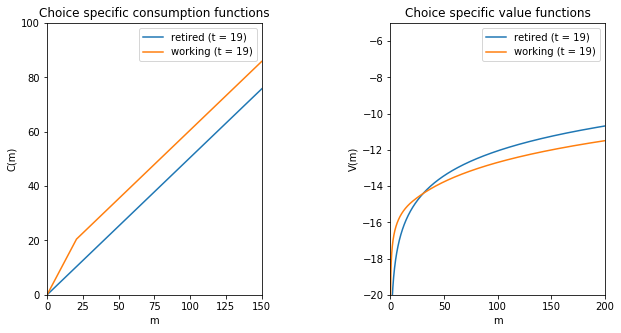

In [9]:
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)
#model.timeRev()
t=19
Tmtm1 = T
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0, 150))
plt.ylim((0, 100))

plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0, 200))
plt.ylim((-20, -5))

We immediately notice two things: the two grids over $m_t$ are different as
the EGM step produces different endogenous grids depending on the discrete
grids (even if the exogenous grids over the post-decision states are the same),
and there are regions where it is optimal to retire (for high $m_t$) and work
(low $M_t$). The intuition should be straight forward. The value function is
the upper envelope of the two choice specific value functions, so it's clear
that it will not be differentiable at that point, and that the resulting
consumption function has a discontinuity at the threshold value of $M_t$.
The authors call these primary kinks.

Since we chose to set the `saveCommon` keyword to `True`, the `solveOnePeriod`
method will also save the consumption function and value function on the common
grid (`model.mGrid`). We can plot this

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(-20, -5)

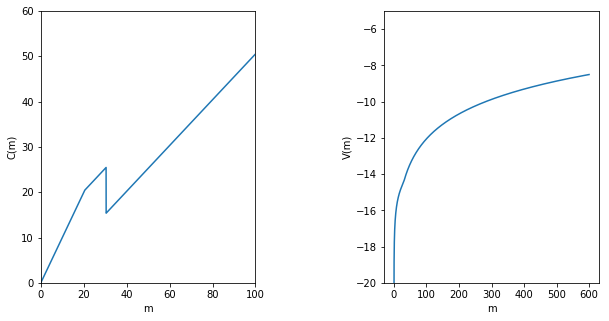

In [10]:
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t = 19
plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 100))
plt.ylim((0, 60))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.ylim((-20, -5))

The "kink" refers to the nondifferentiability in the value function, and we
see the effect quite clearly in the consumption function, where it translates
into a discountinuity. Discontinuities and nondifferentiable points are bad for
any numeric solution method, and this is exactly why we need DCEGM to solve
this model quickly.

Let's go back one period.
It's important to keep in mind that seen from period $t=18$, we have to take
into consideration that varying consumption today may change the wealth tomorrow
in such a way that the optimal decision flips from retirement to work (and the
other way around). Let's plot it.

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in true_divide


(-30, -10)

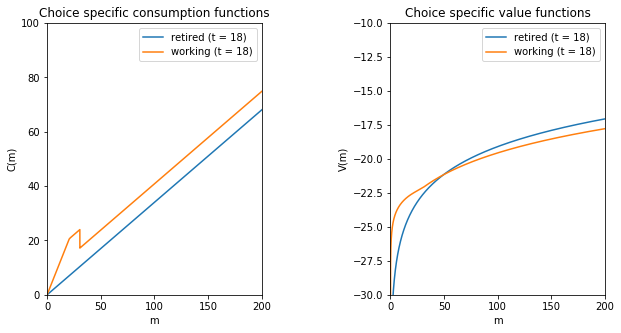

In [11]:
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t=18
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0,200))
plt.ylim((0,100))
plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0,200))
plt.ylim((-30,-10))

This time we see a discontinuity already in the choice specific consumption
function and kinks in the choice specific value functions for the workers!
This is *not* the discontinuity from the retirement threshold in period $t=18$,
but from the "future" discontinuity in $t=19$. We'll first look at the final
consumption function $C_{18}(M)$, and then we'll return to these to these.

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(-1, 200)

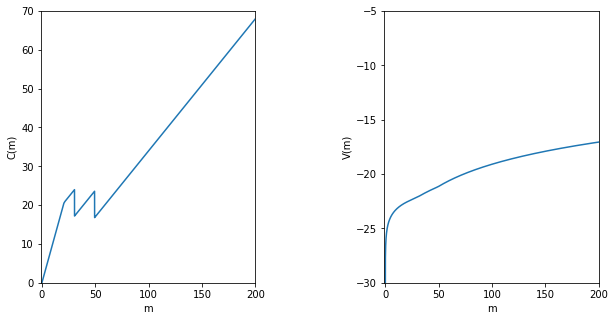

In [12]:
t = 18
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((-1, 200))
plt.ylim((0, 70))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.ylim((-30, -5))
plt.xlim((-1, 200))

We once again see a primary kink and discontinuity, but we also see the the
effect of the retirement behavior at period $t=19$. These are called secondary
kinks. As is maybe clear by now, each period will introduce a new primary kink,
will propogate back through the recursion and become secondary kinks in earlier
periods. Let's finish off by looking at $t=1$

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in true_divide


(-250, -10)

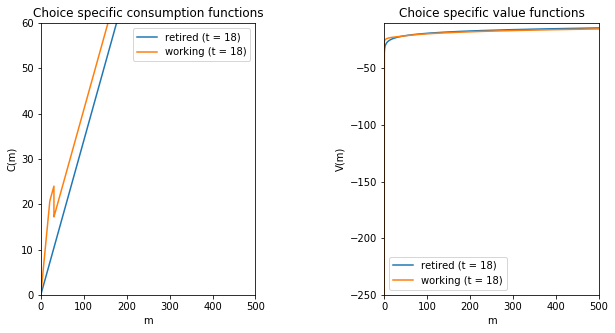

In [39]:
f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t=18
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0, 500))
plt.ylim((0, 60))

plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0, 500))
plt.ylim((-250, -10))

and

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


(-5, 500)

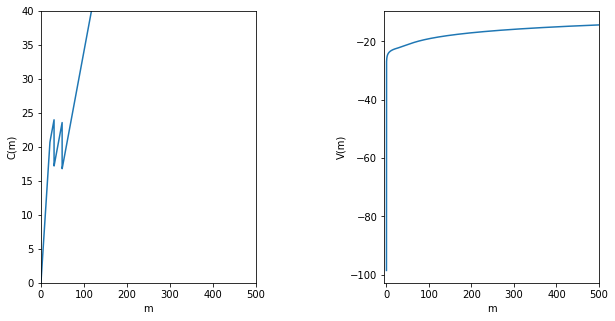

In [40]:
t = 18
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 500))
plt.ylim((0, 40))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.xlim((-5, 500))


# Income uncertainty
Above we saw that the optimal consumption is very jagged: individuals can completely predict their future income given the current and future choices, so they can precisely time their optimal retirement already from "birth". We will now see how adding income uncertainty can smooth out some of these discontinuities: Note, the behavior is certainly rational and optimal, the model just doesn't represent many realistic scenarios we have in mind.

Instead of simply having a constant income given the lagged work/retire decision, we introduce a transitory income shock that is lognormally distributed, and has mean 1. As such, the mean income, conditional on last period's labor decision, is the same in the two model specifications.

..math..

To set a positive variance we specify $\sigma^2$ and the number of nodes used to do quadrature.

In [36]:
#modelTranInc = dcegm.RetiringDeaton(saveCommon = True)
incshk_params = copy.deepcopy(retiring_params)
incshk_params['Rfree'] = 1.00
incshk_params['TranShkCount'] = 100
incshk_params['TranShkStd'] = [sqrt(0.005)]*incshk_params['T']
modelTranInc = RetiringDeaton(**incshk_params)
modelTranInc.solve()

This method only checks for the conditions for infinite horizon models with a 1 period cycle


/home/pkofod/.local/lib/python3.6/site-packages/HARK/utilities.py:138: RuntimeWarning: divide by zero encountered in log
  return np.log(c)
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0,0.5,'V(m)')

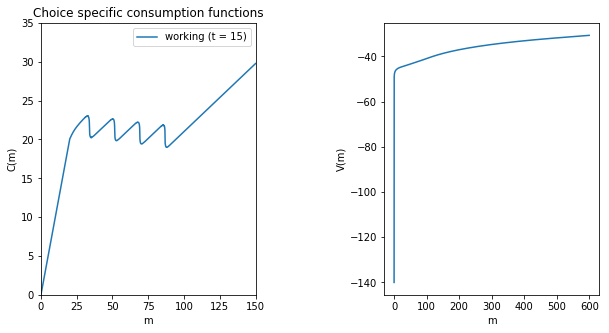

In [37]:

t = 15
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
modelTranInc.plotC(t, 2)
plt.xlim((0,150))
plt.ylim((0,35))
plt.subplot(1,2,2)
plt.plot(modelTranInc.mGrid, numpy.divide(-1.0, modelTranInc.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
#plt.ylim((-120, -50))

We see that way back in period 1, the consumption function is now almost flat. We can control the level of smoothing by increasing or decreasing the variance. Below is an example with a middle ground between the previous two model specifications.

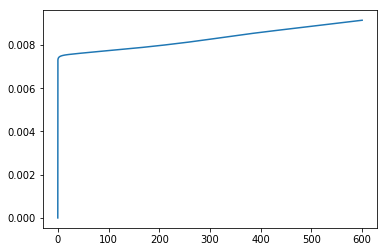

In [17]:
plt.plot(model.solution[1].ChoiceSols[1].m, model.solution[1].ChoiceSols[1].V_TFunc(model.solution[1].ChoiceSols[1].m))

We see it's the secondary kinks from retirement decisions in the near future that gets smoothed out, but the primary kink is obviously still present as it comes from retirement in the current period. The smoothing of secondary kinks from the near future comes from the fact that the consumer does quite know what the income is tomorrow, so the posibility of exact timing of retirement is no longer present.

# Figure 2

This method only checks for the conditions for infinite horizon models with a 1 period cycle


/home/pkofod/.local/lib/python3.6/site-packages/HARK/utilities.py:138: RuntimeWarning: divide by zero encountered in log
  return np.log(c)
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


(0, 40)

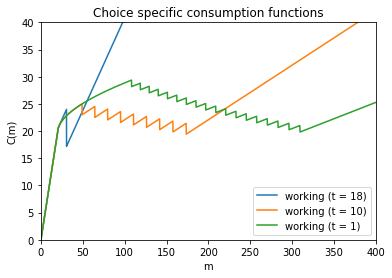

In [49]:
#modelTranIncLight = dcegm.RetiringDeaton(saveCommon = True, TranIncNodes = 20, TranIncVar = 0.001)
retiring_incshk_params = copy.deepcopy(retiring_params)
retiring_incshk_params['Rfree'] = 1.0
model_fig2 = RetiringDeaton(**retiring_incshk_params)
model_fig2.solve()
t = 18
model_fig2.plotC(t, 2)
t = 10
model_fig2.plotC(t, 2)
t = 1
model_fig2.plotC(t, 2)

plt.xlim((0,400))
plt.ylim((0,40))

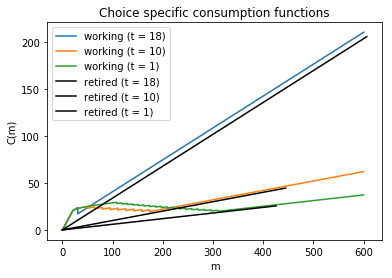

In [43]:
t = 18
model_fig2.plotC(t, 2)
t = 10
model_fig2.plotC(t, 2)
t = 1
model_fig2.plotC(t, 2)
t = 18
model_fig2.plotC(t, 1, color= 'k')
t = 10
model_fig2.plotC(t, 1, color= 'k')
t = 1
model_fig2.plotC(t, 1, color= 'k')

# Figure 3

This method only checks for the conditions for infinite horizon models with a 1 period cycle


/home/pkofod/.local/lib/python3.6/site-packages/HARK/utilities.py:138: RuntimeWarning: divide by zero encountered in log
  return np.log(c)
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


(0, 40)

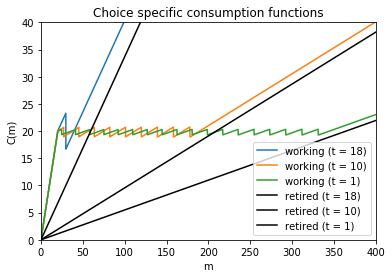

In [42]:
#modelTranIncLight = dcegm.RetiringDeaton(saveCommon = True, TranIncNodes = 20, TranIncVar = 0.001)
fig3_params = retiring_params.copy()
fig3_params['Rfree'] = 1.01
fig3_params['DiscFac'] = 1/fig3_params['Rfree']
model_fig3 = RetiringDeaton(**fig3_params)
model_fig3.solve()
t = 18
model_fig3.plotC(t, 2)
t = 10
model_fig3.plotC(t, 2)
t = 1
model_fig3.plotC(t, 2)
t = 18
model_fig3.plotC(t, 1, color= 'k')
t = 10
model_fig3.plotC(t, 1, color= 'k')
t = 1
model_fig3.plotC(t, 1, color= 'k')

plt.xlim((0,400))
plt.ylim((0,40))

# References
[1] Iskhakov, F. , Jørgensen, T. H., Rust, J. and Schjerning, B. (2017), The endogenous grid method for discrete‐continuous dynamic choice models with (or without) taste shocks. Quantitative Economics, 8: 317-365. doi:10.3982/QE643

[2] Carroll, C. D. (2006). The method of endogenous gridpoints for solving dynamic stochastic optimization problems. Economics letters, 91(3), 312-320.

This method only checks for the conditions for infinite horizon models with a 1 period cycle


/home/pkofod/.local/lib/python3.6/site-packages/HARK/utilities.py:138: RuntimeWarning: divide by zero encountered in log
  return np.log(c)
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


(0, 40)

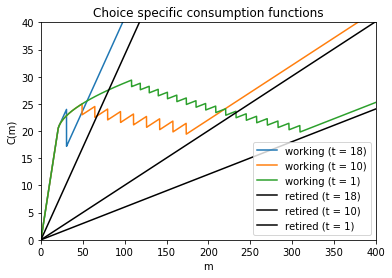

In [41]:
#modelTranInc = dcegm.RetiringDeaton(saveCommon = True)
incshk_params = copy.deepcopy(retiring_params)
incshk_params['Rfree'] = 1.00
incshk_params['DiscFac'] = 0.98
incshk_params['TranShkCount'] = 1
incshk_params['TranShkStd'] = [sqrt(0.000)]*incshk_params['T']
model_fig2 = RetiringDeaton(**incshk_params)
model_fig2.solve()
t = 18
model_fig2.plotC(t, 2)
t = 10
model_fig2.plotC(t, 2)
t = 1
model_fig2.plotC(t, 2)
t = 18
model_fig2.plotC(t, 1, color= 'k')
t = 10
model_fig2.plotC(t, 1, color= 'k')
t = 1
model_fig2.plotC(t, 1, color= 'k')

plt.xlim((0,400))
plt.ylim((0,40))

In [22]:
t = 19
gird = model_fig2.mGrid

Cret = model_fig2.solution[t].ChoiceSols[0].CFunc(gird)
Cwork = model_fig2.solution[t].ChoiceSols[1].CFunc(gird)

Vret = numpy.divide(-1.0, model_fig2.solution[t].ChoiceSols[0].V_TFunc(gird))
Vwork = numpy.divide(-1.0, model_fig2.solution[t].ChoiceSols[1].V_TFunc(gird))

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


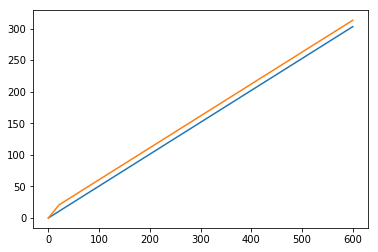

In [23]:
plt.plot(gird, Cret)
plt.plot(gird, Cwork)

(-30, 0)

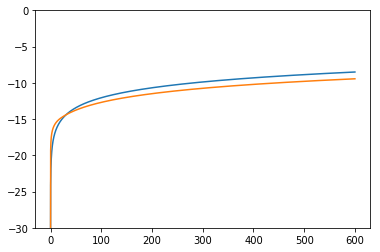

In [24]:
plt.plot(gird, Vret)
plt.plot(gird, Vwork)
plt.ylim((-30,0))

(-50, 0)

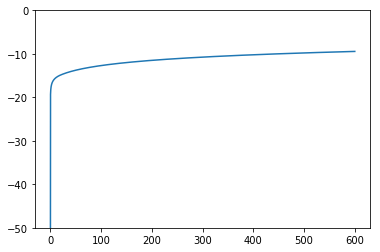

In [25]:

plt.plot(gird, Vwork)
plt.ylim((-50,0))

In [26]:
Vwork

array([         -inf, -293.55448729, -146.70391668, ...,   -9.44532446,
         -9.44340524,   -9.44148595])

In [27]:
Vret

array([        -inf, -55.43014631, -36.21676016, ...,  -8.51037639,
        -8.5083931 ,  -8.50640981])

In [28]:
V,P = calcLogSumChoiceProbs(numpy.stack((Vret, Vwork)), 0.0)

In [29]:
gird

array([0.00000000e+00, 1.49949039e-03, 3.00047975e-03, ...,
       5.98799209e+02, 5.99399304e+02, 5.99999999e+02])

(0, 100)

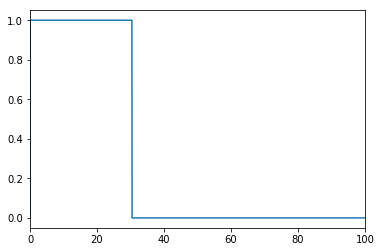

In [30]:
plt.plot(gird,  Vret<Vwork)
plt.xlim((0,100))

In [31]:
model_fig2.Util(600, 1)

-3.6030703447838537

In [32]:
t = 20
gird = model_fig2.mGrid

Cret = model_fig2.solution_terminal.ChoiceSols[0].CFunc(gird)
Cwork = model_fig2.solution_terminal.ChoiceSols[1].CFunc(gird)

Vret = numpy.divide(-1.0, model_fig2.solution_terminal.ChoiceSols[0].V_TFunc(gird))
Vwork = numpy.divide(-1.0, model_fig2.solution_terminal.ChoiceSols[1].V_TFunc(gird))

/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/pkofod/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [33]:
Vret

array([        -inf, -16.50262997, -15.80898309, ...,  -3.60507367,
        -3.60407201,  -3.60307035])